## Problem 2A

#### Suppose that a polar bears foot has a diameter of $l=0.16 m$. 
#### What is the angular size $\delta \theta$ of the foot at an angular diameter distance of $d_A = 0.5 km$? 
The angular size is given as 
$$
\delta \theta = \frac{l}{d_A(z)}
$$.

For $d_A = 0.5 km$ we get
$$
\delta \theta = \frac{0.16 m}{0.5 km}
$$.
Let's compute the actual value

In [1]:
import astropy.units as u

l = 0.16 * u.m
delta_theta1 = l / (0.5 * u.km) * u.rad  # we add the radians to specify that we want to interrete theta as an angle
print(f"delta theta = {delta_theta1.to('arcsec'):.2f}")

delta theta = 66.00 arcsec


### In the current best fit for $\Lambda$ CDM, what is the minimum possible angular size of the polar bears foot?
The minimum angular size is reached when the angular diameter distance $d_A(z)$ reaches the maximum. For a spatially flat ($\Omega_k = 0$) universe with negligable contribution from radiation ($\Omega_r = 0$), it can be expressed as
$$
d_A(z) = \frac{c}{H_0} \frac{1}{1+z} \int _0 ^z \frac{dz'}{\sqrt{\Omega_M (1+z')^3 + \Omega_\Lambda}}
$$.

We will compute this now numerically.

In [3]:
from scipy.integrate import quad
from scipy.optimize import minimize
from astropy.units import Quantity
from astropy import constants
from astropy.cosmology import Planck18 as cosmo
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def d_A(z, omega_m):
    
    def integrand(u):                                                # Here we define a function to compute the integrand
        return 1 / np.sqrt(((omega_m / (1-omega_m)) * (1+u)**3) + 1)   # We call z' u here to not confuse the z from the function input with the integration variable
        
    integral, e = quad(integrand, 0, z)                              # The numerical integration happens here!
                                                                     # The first argument is the function we want to integrate
                                                                     # The second and third arguments are the integration bounds
                                                                     # As a result we get the integral value and an estimation of the uncertainty
                
    pre_f = constants.c / cosmo.H0 / (1+z) / np.sqrt(1 - omega_m)    # Here we just compute the stuff in front of the integral
    
    return pre_f * integral

Before we try to find the minimum value for the angular diameter distance, let's look at what the function looks like for different values of $\Omega_M$ (note that of course we use $\Omega_\Lambda = 1- \Omega_M$)

In [11]:
omega_res = dict()  # Here we create an empte dictionary to store the results in
test_z = np.linspace(0, 8, 1000)  # Here we make a range of redshift values for which we will compute d_A

for omega_m in [0.1, 0.3, 0.9]:  # We loop over some values for Omega_M
    test_dA = Quantity([d_A(iz, omega_m) for iz in test_z])  # We loop over the redshift values and compute d_A using the current value of Omega_M
    
    # As a bonus we want to find the redshift where d_A reaches its maximum
    # There is not function to find the maximum of a function but we just find the minimum of -d_A
    def min_func(z): 
        return -d_A(z, omega_m).value  # the .value is needed because d_A() returns an astropy.units.Quantity and scipy can only deal with floats
    
    zmax_res = minimize(min_func, x0=1)  # We use scipy.optimize.minimize, our first guess of z = 1 is rather arbitrary 
    zmax = zmax_res.x[0]  # This is where the numerical value of the best fit x-value is stored
    
    # Let's save our results in the dictionary
    omega_res[omega_m] = (test_dA, zmax)

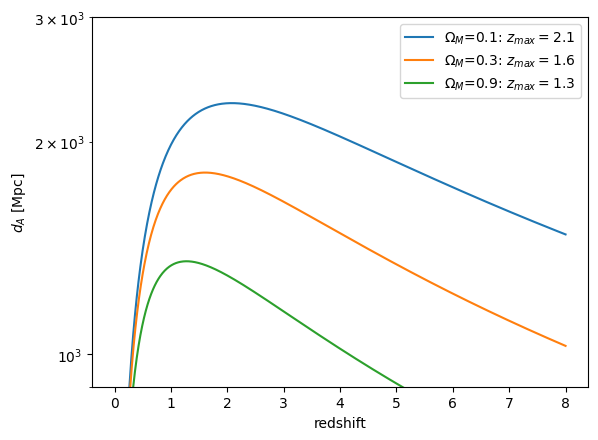

In [12]:
# Now let's plot what we have calculated
# Note: Of course the calculation and plotting coul be done in the same loop but if you want to refine your plots
#       you do not want to recalculate everything. It's good practice to keep them seperate.

fig, ax = plt.subplots()
unit = 'Mpc'

for omega_m, (test_dA, zmax) in omega_res.items():  # We loop over our result dictionary
    ax.plot(test_z, test_dA.to(unit).value, label=f"$\Omega _M$={omega_m}: " + "$z_{max}=$" + f"{zmax:.1f}")
    
ax.set_xlabel('redshift')
ax.set_ylabel(f'$d_A$ [{unit}]')
ax.legend()
ax.set_yscale('log')
ax.set_ylim([900, 3000])

plt.show()
plt.close()

Now let's find the solution for the best fit $\Lambda CDM$ model.

In [13]:
cosmo.Om0  # This the value for Omega_M from the 2018 Planck results

0.30966

In [14]:
def min_func(z): 
    return -d_A(z, cosmo.Om0).value

zmax_res = minimize(min_func, 1)
zmax = zmax_res.x[0]
print(f"The maximum of d_A is at a redshift of {zmax}")

dA_max = d_A(zmax, cosmo.Om0)
print(f"The maximum value of d_A is {dA_max.to('Mpc')}")

l = 0.16 * u.m
dtheta_min = l.to('m') / dA_max.to('m') * u.rad
print(f"For a length of {l}, the minimum angular size is {dtheta_min.to('arcsec')}")

The maximum of d_A is at a redshift of 1.5940715333428968
The maximum value of d_A is 1794.6266157485659 Mpc
For a length of 0.16 m, the minimum angular size is 5.959646035433575e-22 arcsec


## Problem 3

In modern physics it is customary to require a 5σ detection threshold, i.e. a p-value of 10−7, before a detection can be claimed. The moodle page also contains two files, velocities lemaitre.csv and velocities hubble.csv. Each contains the original velocity and distance data used by Lemaitre and Hubble (respectively).
Can you, based on these datasets, argue for who should properly be recognised as the discoverer of the expanding Universe?

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


In [13]:
# Read the data files using pandas library
hubble_data = pd.read_csv('data/hubble.csv')
lemaitre_data = pd.read_csv('data/lem.csv')

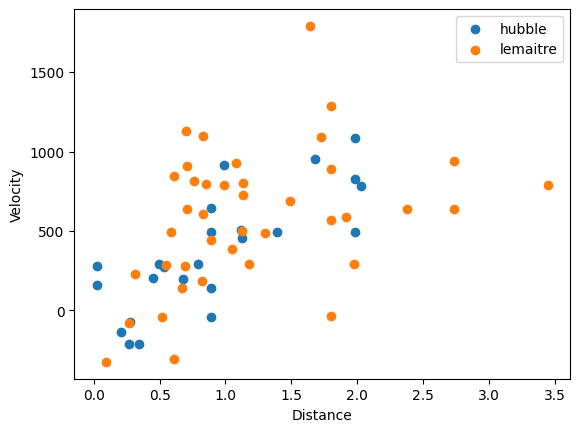

In [ ]:
# Plot thedistribution to get a sense for the data
plt.scatter(hubble_data.distance, hubble_data.velocity, label='hubble')
plt.scatter(lemaitre_data.distance, lemaitre_data.velocity, label='lemaitre')

plt.xlabel('Distance')
plt.ylabel('Velocity')

plt.legend()
plt.show()

In [23]:
from scipy import stats

To test which set of observations match more significantly to the data we can use Spearman's corelation. 

Spearman’s correlation coefficient is a statistical measure of the strength of a monotonic relationship between paired data. It varies between -1 and +1, 
with, 

-1 : Strong negative corelation

+1 : Strong positive corelation

0  : No corelation


Spearman rank-order correlation coefficient : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

In [24]:
# correlation coefficient and p value for Lemaitre's data

stats.spearmanr(lemaitre_data.distance, lemaitre_data.velocity)

SignificanceResult(statistic=0.420509453012302, pvalue=0.006897906803258663)

In [25]:
# correlation coefficient and p value for Hubble's data

stats.spearmanr(hubble_data.distance, hubble_data.velocity)

SignificanceResult(statistic=0.7729157638833444, pvalue=9.545363821344207e-06)

In [26]:
len(hubble_data)

24

### So, the observational data of 40 galaxies by Lemaitre, has a correlation coefficient of 0.42 with a pvalue of 0.006 ~ 2.7 $\sigma$. While the observational data of 24 galaxies by Hubble, has a correlation coefficient of 0.77 with a pvalue of 0.0000095 ~ 4 $\sigma$ detection. If we trust in the mythical 3 sigma as being the threshold for making a discovery, credit for discovery of the velocity-distance relationship goes to Hubble !!! 